# Import

In [1]:
import sys
print(sys.executable)

/opt/anaconda3/envs/URD2/bin/python


In [2]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
import matplotlib.patches as patches

# Run

Pig length (in pixels): 361


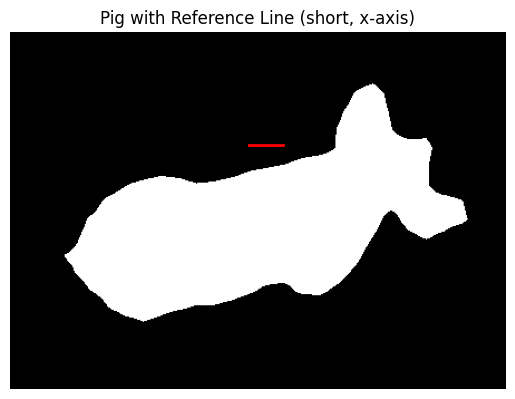

Pig length: 361.00 pixels ≈ 601.67 cm (using reference line)


In [5]:

model = models.segmentation.deeplabv3_mobilenet_v3_large(pretrained=True).eval()


input_image = Image.open('/Users/niner9/Desktop/CMKL/2.1/URD/pig.jpeg')
preprocess = transforms.Compose([
    transforms.Resize(320),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image).unsqueeze(0)

with torch.no_grad():
    output = model(input_tensor)['out'][0]
mask = output.argmax(0).byte().cpu().numpy()

binary_mask = (mask != 0).astype(np.uint8)

labeled, num_features = ndimage.label(binary_mask)

sizes = ndimage.sum(binary_mask, labeled, range(1, num_features + 1))
largest_label = (sizes.argmax() + 1)
pig_mask = (labeled == largest_label)

coords = np.column_stack(np.where(pig_mask))

min_row, min_col = coords.min(axis=0)
max_row, max_col = coords.max(axis=0)

pig_length_pixels = max(max_row - min_row, max_col - min_col)
print("Pig length (in pixels):", pig_length_pixels)

fig, ax = plt.subplots()
ax.imshow(pig_mask, cmap='gray')
#rect = patches.Rectangle((min_col, min_row), max_col - min_col, max_row - min_row,
#linewidth=2, edgecolor='r', facecolor='none')
#ax.add_patch(rect)

center_row = (min_row + max_row) // 3
ref_length = 30 
ref_start_col = min_col + (max_col - min_col - ref_length) // 2
ref_end_col = ref_start_col + ref_length
ax.plot([ref_start_col, ref_end_col], [center_row, center_row], color='red', linewidth=2, label=f'Reference Line ({ref_length} px)')

plt.title("Pig with Reference Line (short, x-axis)")
plt.axis('off')
plt.show()

reference_length_cm = 50 
pixels_per_cm = ref_length / reference_length_cm
pig_length_pixels = max(max_row - min_row, max_col - min_col)
pig_length_cm = pig_length_pixels / pixels_per_cm
print(f"Pig length: {pig_length_pixels:.2f} pixels ≈ {pig_length_cm:.2f} cm (using reference line)")